In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
import sys
sys.executable

'/n/groups/datta/tim_sainburg/conda_envs/mmdeploy/bin/python3'

### important
- must be `module load cuda/11.7`

##### Duration: ???

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from pathlib import Path
import sys
import logging
logging.basicConfig(level=logging.INFO)
print(sys.executable)

/n/groups/datta/tim_sainburg/conda_envs/mmdeploy/bin/python3


In [5]:
from multicamera_airflow_pipeline.tim_240731.keypoints.predict_2D import Inferencer2D

INFO:multicamera_airflow_pipeline.tim_240731.keypoints.predict_2D:Python interpreter binary location: /n/groups/datta/tim_sainburg/conda_envs/mmdeploy/bin/python3


### Get recording info (google sheets)

In [6]:
import requests
import pandas as pd
from io import BytesIO

In [7]:
# spreadsheet_url = 'https://docs.google.com/spreadsheet/ccc?key=14HIqUaSl_n-91hpAvmACY_iVY9nLKdlA6qklhxfZon0&output=csv&gid=0'
spreadsheet_url = "https://docs.google.com/spreadsheet/ccc?key=1jACsUmxuJ9Une59qmvzZGc1qXezKhKzD1zho2sEfcrU&output=csv&gid=0"
response = requests.get(spreadsheet_url)
recording_df = pd.read_csv(BytesIO(response.content))

In [8]:
recording_df[:3]

,Subject,duration_m,video_recording_id,ephys_id,calibration_id,video_location_on_o2,ephys_location_on_o2,calibration_location_on_o2,samplerate,username,n_ephys_streams,max_video_duration_m
0,M04002,10,24-05-01-13-26-43-110846,2024-05-01_13-26-37,24-05-01-13-45-07-825493,/n/groups/datta/tim_sainburg/datasets/chronic2...,/n/groups/datta/tim_sainburg/datasets/chronic2...,/n/groups/datta/tim_sainburg/datasets/chronic2...,150,tis697,1,10


### Run 2D prediction

In [9]:
for idx, recording_row in recording_df.iterrows():
    break

In [10]:
output_directory = Path("/n/groups/datta/tim_sainburg/datasets/scratch/") / "240806-3d-pipeline"

In [11]:
output_directory_2D = output_directory/ "2D_predictions" 

In [12]:
output_directory_2D.mkdir(parents=True, exist_ok=True)

In [13]:
recording_row.video_location_on_o2

'/n/groups/datta/tim_sainburg/datasets/chronic24/video/M04002/'

In [14]:
video_directory = Path(recording_row.video_location_on_o2) / recording_row.video_recording_id

In [15]:
pose_checkpoint = "/n/groups/datta/tim_sainburg/projects/24-01-05-multicamera_keypoints_mm2d/models/rtmpose/rtmpose-m_8xb64-210e_ap10k-256x256_24-05-04-21-35-13_305524/best_PCK_epoch_200.pth"
pose_config = '/n/groups/datta/tim_sainburg/projects/24-01-05-multicamera_keypoints_mm2d/models/rtmpose/rtmpose-m_8xb64-210e_ap10k-256x256_24-05-04-21-35-13_305524/config.py'
det_checkpoint = '/n/groups/datta/tim_sainburg/projects/24-01-05-multicamera_keypoints_mm2d/models/rtmdet/rtmdet_tiny_8xb32-300e_coco_chronic_24-05-04-17-51-58_216661/epoch_400.pth'
det_config = '/n/groups/datta/tim_sainburg/projects/24-01-05-multicamera_keypoints_mm2d/models/rtmdet/rtmdet_tiny_8xb32-300e_coco_chronic_24-05-04-17-51-58_216661/config.py'

In [16]:
tensorrt_path = "/n/groups/datta/tim_sainburg/datasets/scratch/240806-3d-pipeline/tensorrt"
rtmpose_model_name = 'rtmpose-m_8xb64-210e_ap10k-256x256_24-05-04-21-35-13_305524'
rtmdetection_model_name = 'rtmdet_tiny_8xb32-300e_coco_chronic_24-05-04-17-51-58_216661'

In [17]:
output_directory_predictions = output_directory_2D / recording_row.video_recording_id

In [18]:
inferencer = Inferencer2D(
    video_directory,
    output_directory_predictions = output_directory_predictions,
    pose_estimator_config = pose_config,
    pose_estimator_checkpoint = pose_checkpoint,
    detector_config = det_config,
    detector_checkpoint = det_checkpoint,
    tensorrt_rtmdetection_model_name = rtmdetection_model_name,
    tensorrt_rtmpose_model_name = rtmpose_model_name,
    tensorrt_model_directory = tensorrt_path,
    
    use_tensorrt = True,
)

INFO:multicamera_airflow_pipeline.tim_240731.keypoints.predict_2D:Using CUDA device: NVIDIA_L40S
INFO:multicamera_airflow_pipeline.tim_240731.keypoints.predict_2D:Using tensorrt, loading models
loading libmmdeploy_trt_net.so ...
loading libmmdeploy_ort_net.so ...
INFO:multicamera_airflow_pipeline.tim_240731.keypoints.predict_2D:Init completed


### Load pose models

In [19]:
from motpy import Detection, MultiObjectTracker
from mmdet.apis import init_detector, inference_detector
from mmpose.utils import adapt_mmdet_pipeline
from mmpose.apis import inference_topdown, init_model as init_pose_estimator

In [20]:
pose_estimator = init_pose_estimator(
    inferencer.pose_estimator_config.as_posix(),
    inferencer.pose_estimator_checkpoint.as_posix(),
    device="cuda",
    cfg_options=dict(model=dict(test_cfg=dict(output_heatmaps=False))),
)

Loads checkpoint by local backend from path: /n/groups/datta/tim_sainburg/projects/24-01-05-multicamera_keypoints_mm2d/models/rtmpose/rtmpose-m_8xb64-210e_ap10k-256x256_24-05-04-21-35-13_305524/best_PCK_epoch_200.pth


In [21]:
detector = init_detector(
    inferencer.detector_config.as_posix(), inferencer.detector_checkpoint.as_posix(), device="cuda"
)

Loads checkpoint by local backend from path: /n/groups/datta/tim_sainburg/projects/24-01-05-multicamera_keypoints_mm2d/models/rtmdet/rtmdet_tiny_8xb32-300e_coco_chronic_24-05-04-17-51-58_216661/epoch_400.pth


### Load tensortt models

In [22]:
import tensorrt
from mmdeploy_runtime import Detector, PoseDetector

In [25]:
tensortt_detector = inferencer.Detector(
    model_path=inferencer.tensorrt_detection_model_path.as_posix(), device_name="cuda"
)

[2024-08-13 09:20:55.248] [mmdeploy] [info] [model.cpp:35] [DirectoryModel] Load model: "/n/groups/datta/tim_sainburg/datasets/scratch/240806-3d-pipeline/tensorrt/rtmdet_tiny_8xb32-300e_coco_chronic_24-05-04-17-51-58_216661/NVIDIA_L40S"


In [26]:
tensortt_pose_estimator = inferencer.PoseDetector(
    model_path=inferencer.tensorrt_pose_estimator_path.as_posix(), device_name="cuda"
)

[2024-08-13 09:20:59.155] [mmdeploy] [info] [model.cpp:35] [DirectoryModel] Load model: "/n/groups/datta/tim_sainburg/datasets/scratch/240806-3d-pipeline/tensorrt/rtmpose-m_8xb64-210e_ap10k-256x256_24-05-04-21-35-13_305524/NVIDIA_L40S"


### Test run

In [28]:
inferencer.recording_directory

PosixPath('/n/groups/datta/tim_sainburg/datasets/chronic24/video/M04002/24-05-01-13-26-43-110846')

In [29]:
inferencer.all_videos = list(inferencer.recording_directory.glob("*.mp4"))

In [30]:
video_path = inferencer.all_videos[0]

In [31]:
import cv2
import numpy as np
from tqdm.auto import tqdm

In [32]:
detection_interval=5
n_animals=1
total_frames=None
use_motpy=True
n_motpy_tracks=3
use_tensorrt=False
n_keypoints = 25

In [33]:
video = cv2.VideoCapture(video_path.as_posix())

In [34]:
total_frames = 90000

In [35]:
if total_frames is None:
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
if total_frames < 0:
    logger.info(f"Manually counting frames for {video_path}")
    # count frames manually
    total_frames = 0
    with tqdm(desc="counting frames") as pbar:
        while True:
            ret, frame = video.read()
            if not ret:
                break
            total_frames += 1
            pbar.update(1)
    logger.info(f"Total frames: {total_frames}")
    # release and reallocate video
    video.release()
    video = cv2.VideoCapture(video_path.as_posix())


In [36]:
# allocate arrays
detection_coords = np.zeros((total_frames, n_animals, 4))
detection_conf = np.zeros((total_frames, n_animals, 1))
keypoint_coords = np.zeros((total_frames, n_animals, n_keypoints, 2))
keypoint_conf = np.zeros((total_frames, n_animals, n_keypoints))

In [37]:
tracker = MultiObjectTracker(dt=0.1)
animal_ids = {str(i): i for i in range(n_animals)}
bboxes_motpy = np.zeros((n_animals, 4))
confs_motpy = np.zeros((n_animals, 1))
detection_changes = np.zeros((total_frames, n_animals, 1))
missing_detections = np.zeros((total_frames, n_animals, 1))

In [38]:
n_frames = 0
for frame_id in tqdm(range(total_frames), leave=False):
    success, frame = video.read()
    if not success:
        break
    break

  0%|          | 0/90000 [00:00<?, ?it/s]

In [39]:
result = inference_detector(detector, frame)

/n/groups/datta/tim_sainburg/conda_envs/mmdeploy/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1699449201336/work/aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [43]:
result

<DetDataSample(

    META INFORMATION
    img_path: None
    batch_input_shape: (640, 640)
    ori_shape: (1200, 1220)
    scale_factor: (0.5245901639344263, 0.525)
    img_shape: (640, 640)
    img_id: 0
    pad_shape: (640, 640)

    DATA FIELDS
    ignored_instances: <InstanceData(
        
            META INFORMATION
        
            DATA FIELDS
            bboxes: tensor([], device='cuda:0', size=(0, 4))
            labels: tensor([], device='cuda:0', dtype=torch.int64)
        ) at 0x7f76b2351330>
    pred_instances: <InstanceData(
        
            META INFORMATION
        
            DATA FIELDS
            bboxes: tensor([[ 846.0789,  398.0099, 1081.8961,  667.3137],
                        [ 784.1358,  493.8185, 1100.8638,  859.5247],
                        [ 716.9078,  381.5644, 1052.2516,  671.4828],
                        ...,
                        [ 702.6973,  226.9485,  928.8355,  413.5803],
                        [ 614.6066,  523.6096,  996.7943,  894.4401

In [44]:
bboxes = result.pred_instances["bboxes"][:n_motpy_tracks].cpu().numpy()
conf = result.pred_instances["scores"][:n_motpy_tracks].cpu().numpy()

In [65]:
bboxes.shape, conf.shape

((3, 4), (3,))

In [63]:
bboxes, labels, test = tensortt_detector(frame)
conf = bboxes[:n_motpy_tracks,4]
bboxes = bboxes[:n_motpy_tracks,:4]

In [66]:
# attach current tracked frame to previous frames
tracker.step(
    detections=[Detection(box=bboxes[i], score=conf[i]) for i in range(n_motpy_tracks)]
)
tracks = tracker.active_tracks()
track_ids = {i.id: j for j, i in enumerate(tracks)}
track_ids_idx = list(track_ids.keys())
track_score_rank = np.argsort([i.score for i in tracks])[::-1]

# get tracking point for each individual animal
for animal_id in list(animal_ids.keys()):
    # if the id is still being tracked, keep it
    if animal_id in track_ids:
        track = tracks[track_ids[animal_id]]
    else:
        tracking_missed = True
        for rank in track_score_rank:
            if track_ids_idx[rank] not in animal_ids:
                track = tracks[rank]

                # add the new id
                animal_ids[track.id] = animal_ids[animal_id]
                detection_changes[frame_id, animal_ids[animal_id]] = 1
                # remove the previous id
                del animal_ids[animal_id]
                animal_id = track.id
                tracking_missed = False
                break

    if not tracking_missed:
        bboxes_motpy[animal_ids[animal_id]] = track.box
        confs_motpy[animal_ids[animal_id]] = track.score
    else:
        missing_detections[frame_id, animal_ids[animal_id]] = 1

In [67]:
detection_coords[frame_id] = bboxes_motpy
detection_conf[frame_id] = confs_motpy

In [92]:
### non tensorrt version
predictions = inference_topdown(pose_estimator, img=frame, bboxes=bboxes_motpy)
for i in range(n_animals):
    keypoint_coords[frame_id, i, :, :2] = predictions[i].pred_instances.keypoints[
        0
    ]
    keypoint_conf[frame_id, i] = predictions[i].pred_instances.keypoint_scores[0]

In [93]:
keypoint_coords[frame_id, i, :, :2].shape

(25, 2)

In [94]:
keypoint_conf[frame_id, i].shape

(25,)

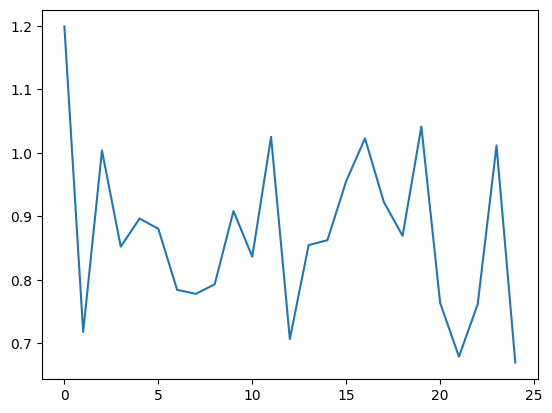

In [95]:
plt.plot(keypoint_conf[frame_id].T)

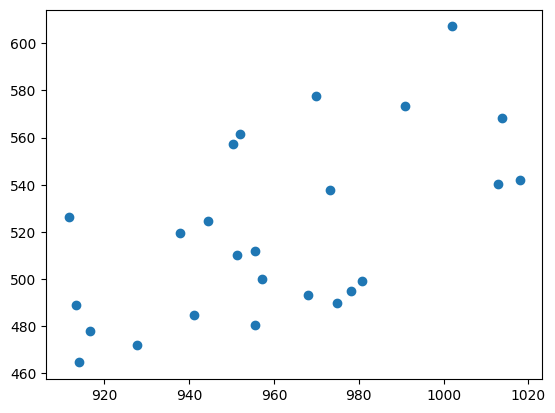

In [96]:
plt.scatter(keypoint_coords[frame_id][0,:,0], keypoint_coords[frame_id][0,:,1])

In [97]:
# tensorrt version
poses = tensortt_pose_estimator(frame, bboxes_motpy.astype(int))
keypoint_coords[frame_id] = poses[:n_animals, :, :2]
keypoint_conf[frame_id] = poses[:n_animals, :, 2]

In [98]:
keypoint_coords[frame_id].shape

(1, 25, 2)

In [99]:
keypoint_coords[0,:,0]

array([[913.3359375 , 465.14453125]])

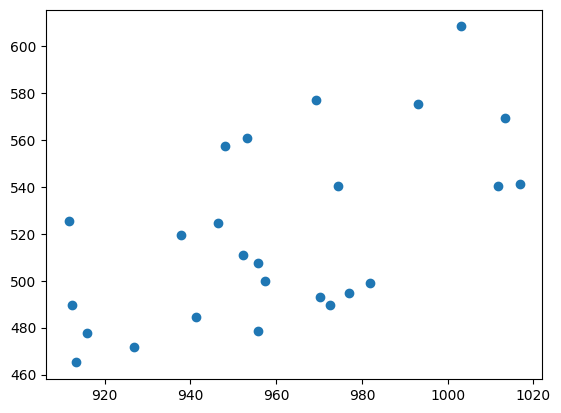

In [100]:
plt.scatter(keypoint_coords[frame_id][0,:,0], keypoint_coords[frame_id][0,:,1])

In [101]:
import matplotlib.pyplot as plt

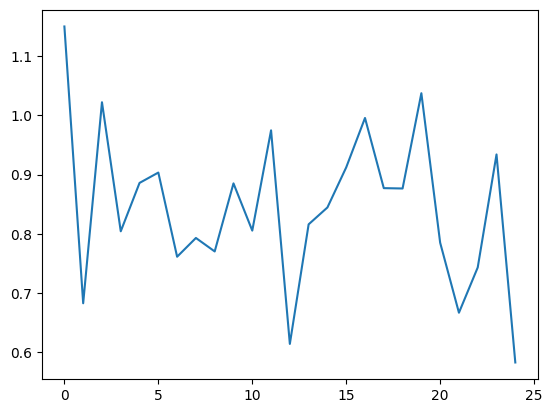

In [84]:
plt.plot(keypoint_conf[frame_id].T)

In [79]:
keypoint_conf[frame_id].shape

(1, 25)

### Test run

In [13]:
inferencer.run()

Loads checkpoint by local backend from path: /n/groups/datta/tim_sainburg/projects/24-01-05-multicamera_keypoints_mm2d/models/rtmpose/rtmpose-m_8xb64-210e_ap10k-256x256_24-05-04-21-35-13_305524/best_PCK_epoch_200.pth
Loads checkpoint by local backend from path: /n/groups/datta/tim_sainburg/projects/24-01-05-multicamera_keypoints_mm2d/models/rtmdet/rtmdet_tiny_8xb32-300e_coco_chronic_24-05-04-17-51-58_216661/epoch_400.pth


  0%|          | 0/12 [00:00<?, ?it/s]

INFO:multicamera_airflow_pipeline.tim_240731.keypoints.predict_2D:Manually counting frames for /n/groups/datta/tim_sainburg/datasets/chronic24/video/M04002/24-05-01-13-26-43-110846/24-05-01-13-26-43-110846.BackBottom.0.mp4
INFO:multicamera_airflow_pipeline.tim_240731.keypoints.predict_2D:Total frames: 90000


  0%|          | 0/90000 [00:00<?, ?it/s]

07/31 17:08:44 - mmengine - WARNING - The current default scope "mmdet" is not "mmpose", `init_default_scope` will force set the currentdefault scope to "mmpose".


/n/groups/datta/tim_sainburg/conda_envs/mmdeploy/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1699449201336/work/aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
INFO:multicamera_airflow_pipeline.tim_240731.keypoints.predict_2D:Manually counting frames for /n/groups/datta/tim_sainburg/datasets/chronic24/video/M04002/24-05-01-13-26-43-110846/24-05-01-13-26-43-110846.BackBottom.90000.mp4
INFO:multicamera_airflow_pipeline.tim_240731.keypoints.predict_2D:Total frames: 9


  0%|          | 0/9 [00:00<?, ?it/s]

INFO:multicamera_airflow_pipeline.tim_240731.keypoints.predict_2D:Manually counting frames for /n/groups/datta/tim_sainburg/datasets/chronic24/video/M04002/24-05-01-13-26-43-110846/24-05-01-13-26-43-110846.BackLeft.0.mp4
INFO:multicamera_airflow_pipeline.tim_240731.keypoints.predict_2D:Total frames: 90000


  0%|          | 0/90000 [00:00<?, ?it/s]

INFO:multicamera_airflow_pipeline.tim_240731.keypoints.predict_2D:Manually counting frames for /n/groups/datta/tim_sainburg/datasets/chronic24/video/M04002/24-05-01-13-26-43-110846/24-05-01-13-26-43-110846.BackLeft.90000.mp4
INFO:multicamera_airflow_pipeline.tim_240731.keypoints.predict_2D:Total frames: 9


  0%|          | 0/9 [00:00<?, ?it/s]

INFO:multicamera_airflow_pipeline.tim_240731.keypoints.predict_2D:Manually counting frames for /n/groups/datta/tim_sainburg/datasets/chronic24/video/M04002/24-05-01-13-26-43-110846/24-05-01-13-26-43-110846.BackRight.0.mp4
INFO:multicamera_airflow_pipeline.tim_240731.keypoints.predict_2D:Total frames: 90000


  0%|          | 0/90000 [00:00<?, ?it/s]

INFO:multicamera_airflow_pipeline.tim_240731.keypoints.predict_2D:Manually counting frames for /n/groups/datta/tim_sainburg/datasets/chronic24/video/M04002/24-05-01-13-26-43-110846/24-05-01-13-26-43-110846.BackRight.90000.mp4
INFO:multicamera_airflow_pipeline.tim_240731.keypoints.predict_2D:Total frames: 9


  0%|          | 0/9 [00:00<?, ?it/s]

INFO:multicamera_airflow_pipeline.tim_240731.keypoints.predict_2D:Manually counting frames for /n/groups/datta/tim_sainburg/datasets/chronic24/video/M04002/24-05-01-13-26-43-110846/24-05-01-13-26-43-110846.FrontBottom.0.mp4
INFO:multicamera_airflow_pipeline.tim_240731.keypoints.predict_2D:Total frames: 90000


  0%|          | 0/90000 [00:00<?, ?it/s]

INFO:multicamera_airflow_pipeline.tim_240731.keypoints.predict_2D:Manually counting frames for /n/groups/datta/tim_sainburg/datasets/chronic24/video/M04002/24-05-01-13-26-43-110846/24-05-01-13-26-43-110846.FrontBottom.90000.mp4
INFO:multicamera_airflow_pipeline.tim_240731.keypoints.predict_2D:Total frames: 9


  0%|          | 0/9 [00:00<?, ?it/s]

INFO:multicamera_airflow_pipeline.tim_240731.keypoints.predict_2D:Manually counting frames for /n/groups/datta/tim_sainburg/datasets/chronic24/video/M04002/24-05-01-13-26-43-110846/24-05-01-13-26-43-110846.FrontLeft.0.mp4
INFO:multicamera_airflow_pipeline.tim_240731.keypoints.predict_2D:Total frames: 90000


  0%|          | 0/90000 [00:00<?, ?it/s]

INFO:multicamera_airflow_pipeline.tim_240731.keypoints.predict_2D:Manually counting frames for /n/groups/datta/tim_sainburg/datasets/chronic24/video/M04002/24-05-01-13-26-43-110846/24-05-01-13-26-43-110846.FrontLeft.90000.mp4
INFO:multicamera_airflow_pipeline.tim_240731.keypoints.predict_2D:Total frames: 9


  0%|          | 0/9 [00:00<?, ?it/s]

INFO:multicamera_airflow_pipeline.tim_240731.keypoints.predict_2D:Manually counting frames for /n/groups/datta/tim_sainburg/datasets/chronic24/video/M04002/24-05-01-13-26-43-110846/24-05-01-13-26-43-110846.FrontRight.0.mp4
INFO:multicamera_airflow_pipeline.tim_240731.keypoints.predict_2D:Total frames: 90000


  0%|          | 0/90000 [00:00<?, ?it/s]

INFO:multicamera_airflow_pipeline.tim_240731.keypoints.predict_2D:Manually counting frames for /n/groups/datta/tim_sainburg/datasets/chronic24/video/M04002/24-05-01-13-26-43-110846/24-05-01-13-26-43-110846.FrontRight.90000.mp4
INFO:multicamera_airflow_pipeline.tim_240731.keypoints.predict_2D:Total frames: 9


  0%|          | 0/9 [00:00<?, ?it/s]